In [51]:
from ultralytics import YOLO
import pickle
import pandas as pd

class TennisBallDetector:
		def __init__(self, model_path):
				self.model = YOLO(model_path)


		def detect_frames(self, frames, output_path=None, stub_path=None):
			'''
			Process the frames and return the detected balls.
			'''
			ball_positions = []
			if stub_path is not None:
				with open(stub_path, 'rb') as f:
					ball_positions = pickle.load(f)
					return ball_positions
			for i, frame in enumerate(frames):
				results = self.results(frame)
				ball_positions.append(results)
			if output_path is not None:
				with open(output_path, 'wb') as f:
					pickle.dump(ball_positions, f)
			return ball_positions

		def results(self, frame):
			'''
			Process the frame and return the detected balls.
			'''
			results = self.model.predict(frame, conf=0.15)[0]
			id_name_dict = results.names
			ball_dict = {}
			for box in results.boxes:
				result = box.xyxy.tolist()[0]
				ball_dict[0] = result
			return ball_dict
		
		def interpolate(self, ball_detections):
			# Replace empty detections with None
			for i, ball in enumerate(ball_detections):
				if not ball:
					ball_detections[i] = None

			data = {
				'frame': list(range(len(ball_detections))),
				'ball_position': ball_detections
			}
			df = pd.DataFrame(data)
			df.set_index('frame', inplace=True)
			df[['x1', 'y1', 'x2', 'y2']] = df['ball_position'].apply(self.extract_coordinates)
			df[['x1', 'y1', 'x2', 'y2']] = df[['x1', 'y1', 'x2', 'y2']].interpolate()
			df['ball_position'] = df.apply(self.assemble_coordinates, axis=1)
			ball_detections = df['ball_position'].tolist()
			# Convert None to empty dict
			for i, ball in enumerate(ball_detections):
				if ball is None:
					ball_detections[i] = {}
			return ball_detections
			
		def extract_coordinates(self, row):
			if row and 0 in row:
					return pd.Series(row[0])
			else:
					return pd.Series([None, None, None, None],dtype=float)
			
		def assemble_coordinates(self, row):
			if not pd.isna(row['x1']):
					return {0: [row['x1'], row['y1'], row['x2'], row['y2']]}
			else:
					return None

In [52]:
def read_frames(cap):
	'''
	Read the frames of a video
	Parameters:
		cap: The video capture object
	Returns:
		frames: A list of frames
	'''
	frames = []
	while True:
		ret, frame = cap.read()
		if not ret: break
		frames.append(frame)
	return frames

In [53]:
import cv2
video_path = f'../data/raw/videos/match02.mp4'
cap = cv2.VideoCapture(video_path)
cap = cv2.VideoCapture(video_path)
# Out Video Configuration
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Frames
frames = read_frames(cap) 

In [54]:
ball_detector = TennisBallDetector('../models/tennis_ball/last.pt')

In [70]:
ball_detections = ball_detector.detect_frames(frames,stub_path=f'../output/stubs/balls-match02.pkl')
ball_detections = ball_detector.interpolate(ball_detections)
# Filter out empty detections (empty keys)
ball_positions = [ball[0][1] for ball in ball_detections if ball]

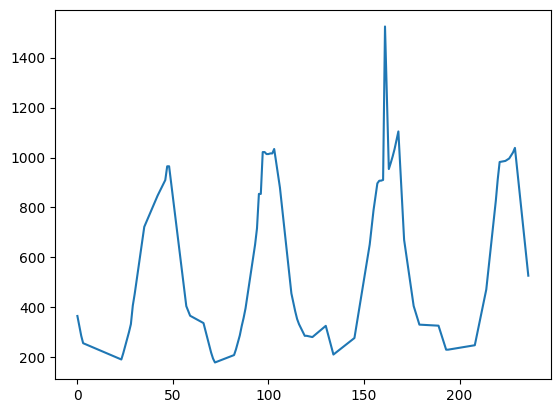

In [72]:
# Plot all the detections - x index is the frame number

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

number_of_frames = len(ball_positions)
velocities = np.diff(ball_positions, n=1)
# Detect zero crossings
frame_numbers = np.arange(0, number_of_frames)
zero_crossings = np.where(np.diff(np.sign(velocities)))[0]
plt.plot(frame_numbers[:-1], ball_positions[:-1], label='Ball Position')

In [73]:
# Calculate average height
average_height = np.mean(ball_positions)

In [78]:
# Thresholds for significant deviation and minimum number of consecutive points
deviation_threshold = 30  # adjust based on your observations
min_consecutive_points = 10  # number of consecutive points to confirm a trend

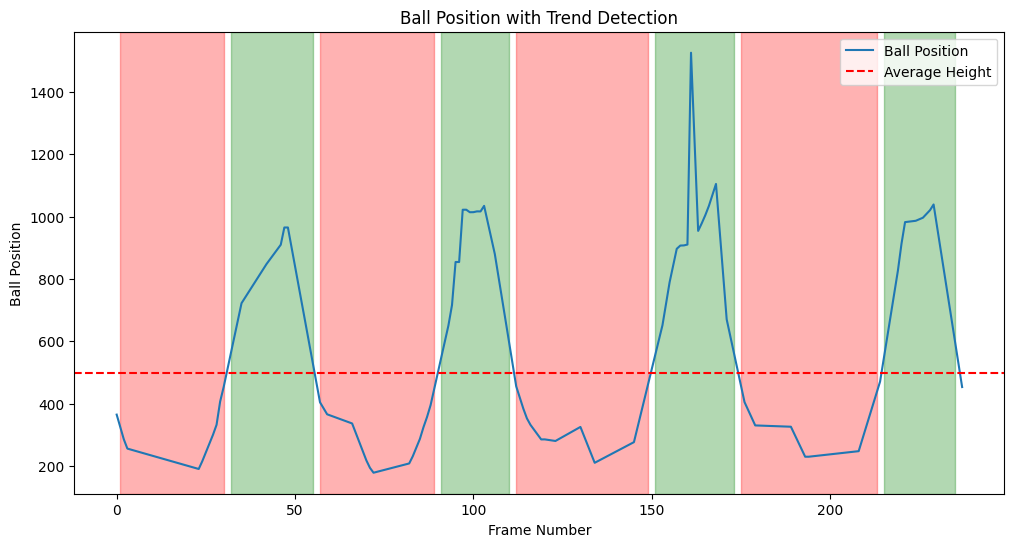

In [79]:
# Identify significant slopes
trends = []
current_trend = {'start': None, 'type': None}
for i in range(1, len(ball_positions)):
    if (ball_positions[i] > average_height + deviation_threshold and
        (current_trend['type'] == 'up' or current_trend['type'] is None)):
        if current_trend['type'] is None:
            current_trend['start'] = i
        current_trend['type'] = 'up'
    elif (ball_positions[i] < average_height - deviation_threshold and
          (current_trend['type'] == 'down' or current_trend['type'] is None)):
        if current_trend['type'] is None:
            current_trend['start'] = i
        current_trend['type'] = 'down'
    else:
        if current_trend['type'] is not None and i - current_trend['start'] > min_consecutive_points:
            trends.append((current_trend['start'], i - 1, current_trend['type']))
        current_trend = {'start': None, 'type': None}

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ball_positions, label='Ball Position')
plt.axhline(y=average_height, color='r', linestyle='--', label='Average Height')
for start, end, t_type in trends:
    plt.axvspan(start, end, color='green' if t_type == 'up' else 'red', alpha=0.3)
plt.title('Ball Position with Trend Detection')
plt.xlabel('Frame Number')
plt.ylabel('Ball Position')
plt.legend()
plt.show()

In [82]:
# Derivate the ball positions to get the velocities
velocities = np.diff(ball_positions, n=1)

In [95]:
# Get interceptions with the average height
interceptions = []
for i in range(1, len(ball_positions)):
		if (ball_positions[i] > average_height and ball_positions[i-1] < average_height) or \
			 (ball_positions[i] < average_height and ball_positions[i-1] > average_height):
				interceptions.append(i)
	

[]
